![](../JFM-notebooks-logo.jpg)

In [1]:
import numpy as np
import sys, os, h5py
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

# Aesthetics
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper')
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='serif')

cspeed = cmocean.tools.crop_by_percent(cmocean.cm.tempo, 30, which='both', N=None)

import pandas as pd

### Load sheared VC data

In [2]:
df = pd.read_csv('../data/P-VC_global_response.csv')
df.head()

Ra   Pr      Re        Uf        Ub        Uc        UL        nu  \
0  10000000.0  1.0   316.0  1.000000  0.099928  0.110069  0.481715  0.000316   
1  10000000.0  1.0  1000.0  1.000000  0.316228  0.353134  0.532587  0.000316   
2  10000000.0  1.0  1780.0  1.000000  0.562885  0.627192  0.588370  0.000316   
3  10000000.0  1.0  3160.0  1.000000  0.999280  1.115123  0.676748  0.000316   
4  10000000.0  1.0  5620.0  0.562683  1.000000  1.118777  0.439714  0.000178   

       tauu      tauw  ...       Cfw          Rew         Red          Rec  \
0  0.000720  0.010070  ...  0.086788  1523.316245   90.290854   348.068405   
1  0.002316  0.010586  ...  0.074643  1684.188889   99.826188  1116.707042   
2  0.004308  0.011177  ...  0.064573  1860.588872  118.881688  1983.354264   
3  0.008114  0.012164  ...  0.053119  2140.064636  136.738696  3526.327103   
4  0.005193  0.004340  ...  0.044898  2471.801870  157.934933  6289.079322   

         UR      tauR       Red0       Nu0      Cfw0          Re0  
0  0.484970  0.010106  90.901014  13.75895  0.085941  1533.610379  
1  0.484970  0.010106  90.901014  13.75895  0.085941  1533.610379  
2  0.484970  0.010106  90.901014  13.75895  0.085941  1533.610379  
3  0.484970  0.010106  90.901014  13.75895  0.085941  1533.610379  
4  0.272884  0.003200  90.901014  13.75895  0.085941  1533.989069  

[5 rows x 23 columns]

### Load sheared RB data

In [3]:
PRB_df = pd.read_csv('../data/P-RB_global_response.csv')
PRB_df.head()

Averaging time  Bulk Reynolds  Centerline Reynolds  \
0      726.750004           10.0            12.999871   
1      748.600001           20.0            24.962705   
2      719.899999           30.0            37.650986   
3      695.300005           40.0            50.564644   
4      746.150002           50.0            65.820800   

   Friction Reynolds (outfile)  Friction Reynolds (stafield)  \
0                     5.173013                      5.194237   
1                     7.589227                      7.756306   
2                     9.224198                      9.354980   
3                    10.787703                     10.892102   
4                    11.430479                     11.455316   

   Friction Reynolds (std. dev)  Nusselt (out file)  Nusselt (stafield)  \
0                      1.112193           16.192182           16.195277   
1                      0.857962           16.126511           16.125382   
2                      0.792945           16.110101           16.110612   
3                      0.661293           16.100464           16.101657   
4                      0.556352           16.103329           16.101728   

   Nusselt (std. dev)  Prandtl  ...  RMS Reynolds (stafield)  \
0            0.120351      5.0  ...               179.249520   
1            0.108958      5.0  ...               180.061660   
2            0.115645      5.0  ...               182.113507   
3            0.114546      5.0  ...               183.466436   
4            0.123334      5.0  ...               185.737044   

   RMS Reynolds (std. dev)  RMS Spanwise Boundary Layer (stafield)  \
0                 2.316958                                0.094059   
1                 1.968642                                0.090521   
2                 2.346868                                0.090521   
3                 2.596448                                0.090521   
4                 2.529311                                0.101317   

   RMS Spanwise Friction Reynolds (stafield)  \
0                                  67.141265   
1                                  64.576807   
2                                  64.951287   
3                                  64.236294   
4                                  67.195488   

   RMS Spanwise Reynolds (stafield)    Rayleigh       Red0       Cf0  \
0                        131.225401  10000000.0  16.676619  0.381491   
1                        113.948484  10000000.0  16.676619  0.381491   
2                        116.572873  10000000.0  16.676619  0.381491   
3                        110.843101  10000000.0  16.676619  0.381491   
4                        135.949415  10000000.0  16.676619  0.381491   

          Re0        Nu0  
0  179.112719  16.141065  
1  179.112719  16.141065  
2  179.112719  16.141065  
3  179.112719  16.141065  
4  179.112719  16.141065  

[5 rows x 24 columns]

### Define quantities to be plotted ($C_f=8 (Re_\tau/Re)^2$ and $Gr=Ra/Pr$)

In [4]:
# P-VC
df['Gr'] = df.Ra/df.Pr

# P-RB
PRB_df['Gr'] = PRB_df.Rayleigh/PRB_df.Prandtl
PRB_df['Cf'] = 8*(PRB_df['Friction Reynolds (stafield)']/PRB_df['Bulk Reynolds'])**2

### Write function to solve Prandtl friction law prediction

In [5]:
from scipy.optimize import newton
def Cfunc(Reb):
    Cf = np.zeros(Reb.size)
    for i in range(Reb.size):
        def f(x):
            # k = 0.41
            # B = 5
            k = 0.384
            B = 4.27
            return (2/x)**0.5 - 1/k*np.log(Reb[i]/2*(x/2)**0.5) - B
        Cf[i] = newton(f, 2.5e-3)
    return Cf

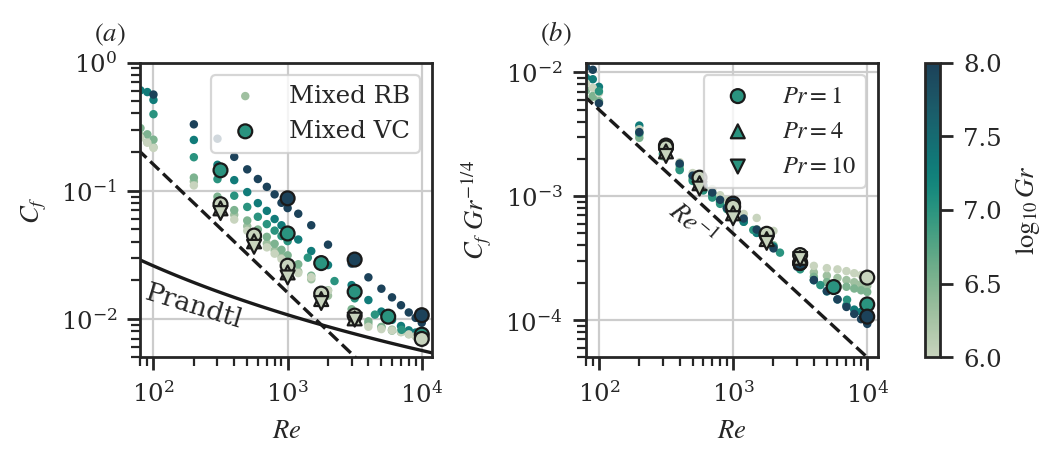

In [6]:
fig, axs = plt.subplots(1,2, figsize=(5.2,2.2), layout='constrained', dpi=200, sharex=True)

cmap = cspeed

ax = axs[0]

# Plot P-RB data
sc = ax.scatter(PRB_df['Bulk Reynolds'], PRB_df.Cf, c=np.log10(PRB_df.Gr), cmap=cmap, s=5, label='Mixed RB')

# Plot P-VC data
ax.scatter(df.Re*(df.Pr==1), df.Cfu*(df.Pr==1), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, label='Mixed VC')
ax.scatter(df.Re*(df.Pr==4), df.Cfu*(df.Pr==4), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, marker='^')
ax.scatter(df.Re*(df.Pr==10), df.Cfu*(df.Pr==10), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, marker='v')

fig.colorbar(sc, ax=axs, label='$\log_{10} Gr$')


# Add theoretical predictions for comparison
R = 10**np.linspace(1.5,4.5,101)
ax.loglog(R, 16*R**-1, 'k--')
ax.loglog(R, Cfunc(R), 'k-')
ax.set(
    xlabel='$Re$',
    ylabel='$C_f$',
    xlim = [8e1,1.2e4],
    ylim=[5e-3,1]
)
ax.annotate('Prandtl', (2e2, 1.25e-2), ha='center', va='center', rotation=-17)

# Labels and aesthetics
ax.grid(True)
ax.legend()
ax.annotate('$(a)$', (-0.05, 1.05), xycoords='axes fraction', ha='right', va='bottom')


ax = axs[1]

# P-RB
ax.scatter(PRB_df['Bulk Reynolds'], PRB_df.Cf/PRB_df.Gr**0.25, c=np.log10(PRB_df.Gr), cmap=cmap, s=5)

# P-VC
ax.scatter(df.Re*(df.Pr==1), df.Cfu/df.Gr**0.25*(df.Pr==1), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, label='$Pr=1$')
ax.scatter(df.Re*(df.Pr==4), df.Cfu/df.Gr**0.25*(df.Pr==4), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, marker='^', label='$Pr=4$')
ax.scatter(df.Re*(df.Pr==10), df.Cfu/df.Gr**0.25*(df.Pr==10), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, marker='v', label='$Pr=10$')

# Add theoretical comparison
R = 10**np.linspace(1.5,4,101)
ax.loglog(R, 0.5*R**-1, 'k--')
ax.semilogx()

# Labels and aesthetics
ax.set(
    xlabel='$Re$',
    ylabel='$C_f\ Gr^{-1/4}$',
    ylim=[5e-5, 1.2e-2]
)
ax.annotate('$Re^{-1}$', (500, 6e-4), ha='center', va='center', rotation=-40)
ax.grid(True)
ax.legend()
ax.annotate('$(b)$', (-0.05, 1.05), xycoords='axes fraction', ha='right', va='bottom')


# fig.savefig('Horizontal_friction_coefficients.pdf')

plt.show()